# [CIFAR-10 Image Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

## Dataset Load

In [298]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pyprind
%matplotlib inline

In [299]:
def unpickleCifar(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='bytes')
    fo.close()
    return dict

In [300]:
trainX = np.array([], dtype=np.uint8)
trainX.shape=(0, 3072)
trainY = np.array([], dtype=np.int32)
for i in range(1, 6):
    batch = unpickleCifar('data_batch_%d'%i)
    trainX = np.concatenate((trainX, batch[b'data']), axis = 0)
    trainY = np.concatenate((trainY, batch[b'labels']), axis = 0)

In [301]:
testBatch = unpickleCifar('test_batch')
testX = testBatch[b'data']
testY = testBatch[b'labels']

In [302]:
batches_meta = unpickleCifar('batches.meta')

In [303]:
labels = [l.decode() for l in batches_meta[b'label_names']]
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

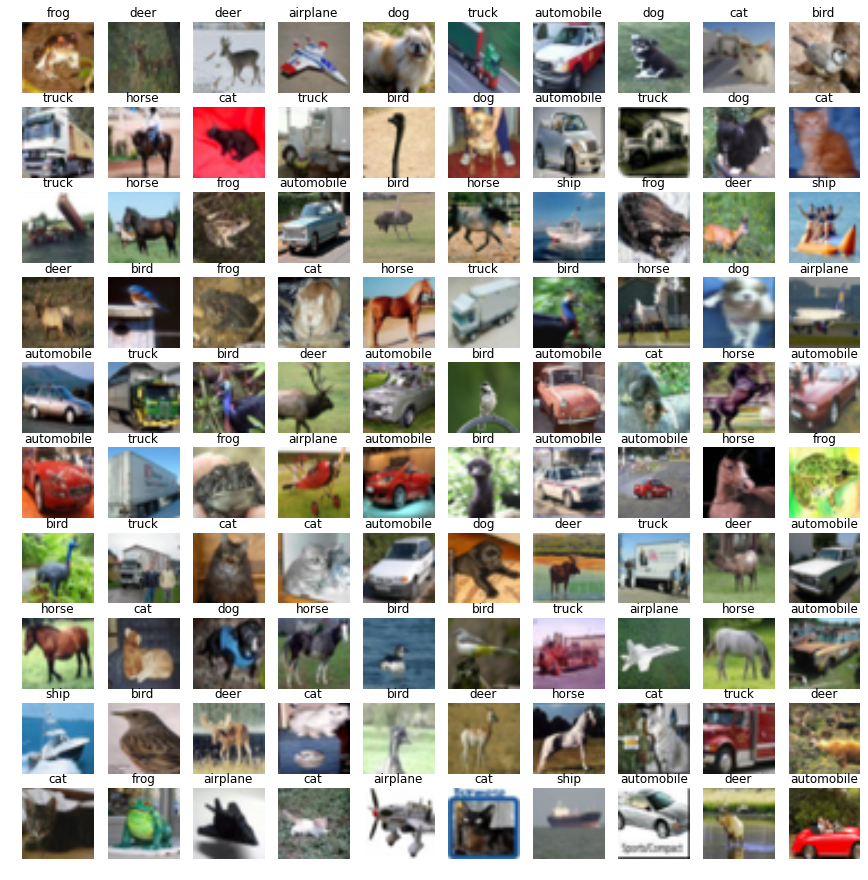

In [304]:
fig, ax = plt.subplots(nrows=10, ncols=10)

for i in range(0, 10):
    for k in range(0, 10):
        ax[i, k].imshow(trainX[i + k*10].reshape(3, 32, 32).transpose(1, 2, 0))
        ax[i, k].set_axis_off()
        ax[i, k].set_title(labels[trainY[i + k*10]])
    
fig.set_size_inches((15, 15))

## SVM Classifier

In [305]:
np.random.seed(100)

In [306]:
mean, std = np.mean(trainX), np.std(trainX)

trainX = (trainX - mean)/std
trainX = np.concatenate((np.ones(shape=(trainX.shape[0], 1), dtype=np.uint8), trainX), axis=1)

testX = (testX - mean)/std
testX = np.concatenate((np.ones(shape=(testX.shape[0], 1), dtype=np.uint8), testX), axis=1)

In [297]:
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [327]:
#%%writefile SVMClassifier.py
class SVMClassifier:
    losses = []
    batchLosses = []
    
    def __init__(self, epochs=300, learningRate=0.00005, batchSize=250):
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        
    def forwardPropagation(self, W, X, vectY):
        # 1
        self.f1 = W.dot(X.T)
        # 2
        self.f2 = self.f1 * vectY
        #3
        self.f3 = np.sum(self.f2, axis=0)
        #4
        self.f4 = self.f1 - self.f3 + 1
        #5
        self.f5 = self.f4*(1-vectY)
        #6
        self.f6 = np.maximum(self.f5, 0)
        #7
        self.f7 = np.sum(self.f6)
        #8
        self.f8 = self.f7/len(X)
        
        loss = np.sum(self.f8)
        return loss
    
    def backPropagation(self, X, vectY):
        #8
        df7 = 1/len(X)
        #7
        #df7 = np.ones(shape = self.f7.shape)
        df6 = np.ones(shape=self.f6.shape) * df7
        #6
        #df6 = np.ones(shape = self.f6.shape)
        df5 = np.array(self.f5 > 0, dtype = np.float32) * df6
        #5
        #df5 = np.ones(shape = self.f5.shape)
        df4 = df5*(1 - vectY)
        #4
        #df4 = np.ones(shape = self.f4.shape)
        df3 = -1*np.ones(shape=self.f3.shape)*np.sum(df4, axis = 0)
        #3+2
        df1 = df4
        df2 = df3
        df1 += df2*vectY
        #1
        #df1 = np.ones(shape = self.f1.shape)*(1-vectY)
        dW = df1.dot(X)
        
        
        #df4 = np.ones(shape = self.f4.shape)
        #df3 = -self.f1.shape[0]*df4
        #df1 = df4
        #df2 = np.ones(shape = self.f2.shape)*df3
        #df1 += vectY*df2
        #dW = df1.dot(X)
        
        grad = dW
        return grad
    
    def fit(self, X, y):
        self.losses = []
        self.batchLosses = []
        self.labelsCardinality = len(np.unique(y))
        self.W = np.random.randn(self.labelsCardinality, X.shape[1])
        vectY = np.zeros(shape=(self.labelsCardinality, X.shape[0]))
        for i in range(0, X.shape[0]):
            vectY[y[i], i] = 1

        bar = pyprind.ProgBar(self.epochs*len(X)/self.batchSize, bar_char='█', width=70)
        for i in range(0, self.epochs):
            loss = self.forwardPropagation(self.W, X, vectY)
            self.losses.append(loss)
            #logging.info(loss)
            indexes = np.arange(0, len(X))
            np.random.shuffle(indexes)
            trainX = X[indexes]
            trainY = y[indexes]
            for batch in range(0, len(X), self.batchSize):
                batchX = trainX[batch:batch+self.batchSize]
                batchY = trainY[batch:batch+self.batchSize]
                batchVectY = np.zeros(shape=(self.labelsCardinality, batchX.shape[0]))
                for i in range(0, batchX.shape[0]):
                    batchVectY[batchY[i], i] = 1
                batchLoss = self.forwardPropagation(self.W, batchX, batchVectY) 
                self.batchLosses.append(batchLoss)
                grad = self.backPropagation(batchX, batchVectY)
                self.W += -self.learningRate*grad
                bar.update(item_id = "%.2f, %.2f"%(loss, batchLoss))
        print(bar)
    
    def predict(self, X):
        return np.argmax(self.W.dot(X.T), axis=0)

In [361]:
svm = SVMClassifier(epochs=200, learningRate=0.01)
svm.fit(trainX, trainY)

0%                                                                  100%
[██████████████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: 8.45, 7.16
Total time elapsed: 00:05:58


Title: 
  Started: 06/09/2016 21:57:55
  Finished: 06/09/2016 22:03:54
  Total time elapsed: 00:05:58


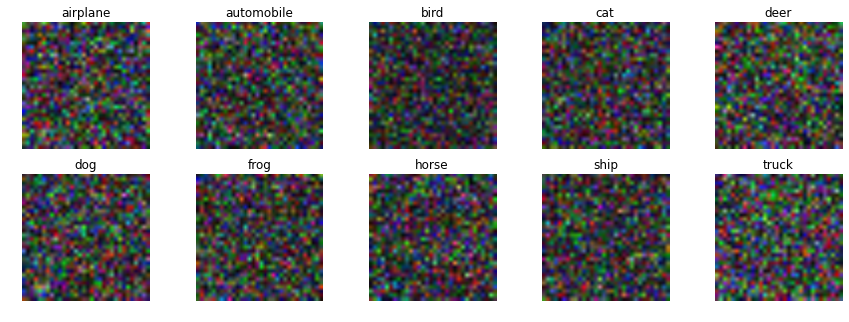

In [360]:
fig, ax = plt.subplots(nrows=2, ncols=5)

for i in range(0, 2):
    for k in range(0, 5):
        weights = np.abs(svm.W[i*5 + k, 1:])
        weights = weights/np.max(weights)
        weights = np.array(weights*300, dtype=np.uint8)
        ax[i, k].imshow(weights.reshape(3, 32, 32).transpose(1, 2, 0))
        ax[i, k].set_axis_off()
        ax[i, k].set_title(labels[i*5 + k])
    
fig.set_size_inches((15, 5))

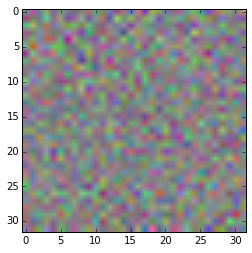

In [332]:
weights = svm.W[0, 1:] - np.min(svm.W[0, 1:])
weights = weights/np.max(weights)
weights = np.array(weights*255, dtype=np.uint8)
plt.imshow(weights.reshape(3, 32, 32).transpose(1, 2, 0))

/Users/kirill/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


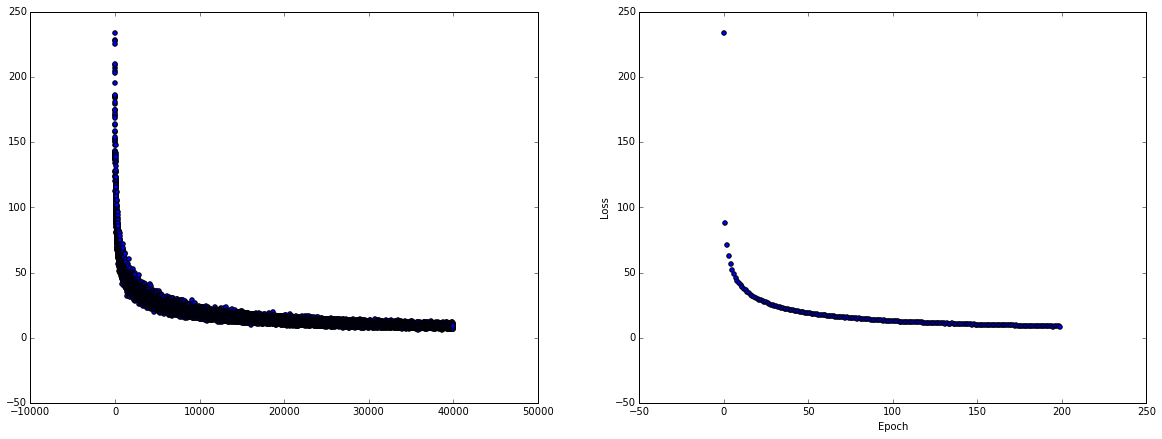

In [340]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(np.arange(0, len(svm.batchLosses)), svm.batchLosses)
plt.xlabel('Batch Epoch')
plt.ylabel('Batch Loss')

ax[1].scatter(np.arange(0, len(svm.losses)), svm.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

fig.set_size_inches((20, 7))

In [334]:
svm.losses[-1]

5.0765452090296224

In [338]:
np.sum(svm.predict(trainX) == trainY)/len(trainX)

0.34455999999999998

In [339]:
np.sum(svm.predict(testX) == testY)/len(testX)

0.30259999999999998

In [56]:
import tensorflow as tf

session = tf.InteractiveSession()

/Users/kirill/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [109]:
X = tf.placeholder(dtype=tf.float32, shape=(None, trainX.shape[1]))
y = tf.placeholder(dtype=tf.float32, shape=(None))
W = tf.Variable(np.random.randn(len(labels), trainX.shape[1]), dtype=tf.float32)

vectY = np.zeros(shape=(len(labels), trainX.shape[0]))
for i in range(0, trainX.shape[0]):
    vectY[trainY[i], i] = 1
    
y_actual = tf.placeholder(dtype=tf.float32, shape=(len(labels), None))

ypred = tf.matmul(W, tf.transpose(X))
t = tf.reduce_sum(tf.mul(ypred, y_actual), 0)
diff = ypred - t + 1
diff = tf.sub(diff, tf.mul(diff, y_actual))
cost = tf.reduce_sum(tf.maximum(diff, 0.0)) / len(trainX)

# gradient descent operation. Essentially, it just executes feedforward transformation followed
# by backpropagation so weights get updated. This operation plays a role of a single epoch.
costMinimizer = tf.train.GradientDescentOptimizer(.5).minimize(cost)

session.run(tf.initialize_all_variables())
costs = []
n = 1
#bar = pyprind.ProgBar(n, bar_char='█', width=100)
for i in range(0, n):
    # compue one gradient descent epoch. Here is the place where computational graph gets feeded
    # to the computational engine and executed.
    session.run(costMinimizer, feed_dict = {X: trainX, y: trainY, y_actual: vectY})
    # calculate the cost and append it to the list for logging purposes
    costs.append(cost.eval(feed_dict = {X: trainX, y: trainY, y_actual: vectY}))
    logging.info(costs[-1])
    #bar.update()
    
# outputs weights tensor
W.eval()

09:19:06 INFO:460.167


array([[ 0.53427917,  0.96531236, -1.3553561 , ..., -0.37254626,
         1.59878016,  3.07094502],
       [-1.58949924,  0.65481567, -0.35985103, ..., -1.95405269,
         1.34849465,  0.09779607],
       [-0.10365456, -0.95407695,  2.03542829, ...,  0.26856041,
         0.58374047, -0.61207753],
       ..., 
       [-0.3738088 ,  1.17525566,  0.40201896, ...,  1.31830943,
         1.05195653, -1.11632717],
       [ 0.54915464, -0.38829964,  0.47583413, ...,  0.2735208 ,
        -0.33835095,  1.57920158],
       [ 0.44893277,  1.9849242 ,  1.41247666, ..., -1.48739028,
        -0.60785997,  0.99024391]], dtype=float32)

/Users/kirill/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


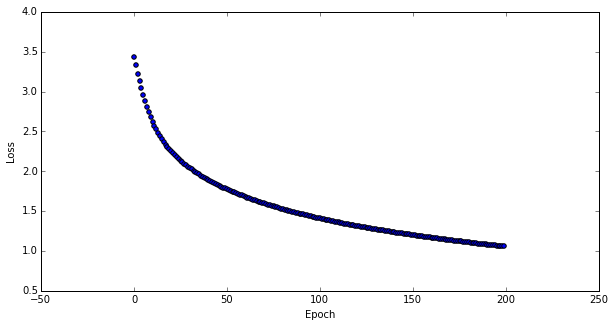

In [98]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(0, n), costs)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [99]:
np.sum(np.argmax(np.dot(W.eval(), trainX.T), axis=0) == trainY)/len(trainX)

0.12306